# Discovering and Learning the 1D Swift Hohenberg Equation

This file implements the Physics Informed Neural Networks (PINN) and Deep Hidden Phyics Models (DHPM) classes written by Maizar Raissi and applies them to the Swift-Hohenberg equation.

## Set Up and Introduction 
It is important to note that this file uses version 1.14 of Tensorflow and Python 3.7 and will not be compatible with newer versions. For aesthetic reasons when compiling this notebook, we choose to temporarily suppress warnings (this is not a good thing to do all the time). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import scipy.io
import scipy.stats
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

In [2]:
tf.__version__

'1.14.0'

In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)

import sys
sys.path.insert(0, '../../Utilities/')

Configure the file path here -- use cd and ls. 

In [4]:
ls

Burger_discover_exact.pdf           SH_1D-Class.ipynb
Burger_discover_pred.pdf            SH_1D.ipynb
Burger_exact.pdf                    SH_1Dtf26.ipynb
Burger_predict.pdf                  SH_mat.m
Burger_slice.pdf                    SH_mat2.asv
HD_rolls_1_1_discover.pdf           SH_mat2.m
HD_rolls_1_1_discover.png           Untitled.ipynb
HD_rolls_1_1_discover_bad.png       Untitled1.ipynb
HD_rolls_1_2_discover.png           __pycache__/
HD_rolls_1_2_discover_bad.pdf       burger_final.ipynb
HD_rolls_1_int_slice.png            burgers_shock.mat
HD_rolls_1_mix_slice.png            cylinder_nektar_wake.mat
HD_rolls_1_pred.png                 data/
HD_rolls_1_pred_int.png             pdfHD_rolls_1_1_discover_exact.pdf
HD_rolls_1_pred_mix.png             pred_burger.ipynb
HD_rolls_1_pred_noise.png           sh_rolls_test.mat
HD_rolls_1_pred_noise_slice.png     sh_test.mat
HD_rolls_1_slice.png                slice_pred.png
HD_rolls_1_true.png                 slice_real.png
HD_rolls_2_tru

Now we load the PINN class. Note that none of the functions or code in this class are my own, but most of the function documentation was added by me. 

## Prediction

In this section, we will work with unperturbed data only. The initial value problem we will be interested in as as follows: 

\begin{align*}u_t & = -u_{xxxx} - 2 u_{xx} +(-1+\mu)u + \nu u^2 - u^3, \qquad\qquad x \in [0,20], \quad t \in [0,5] \\
u(0,x) & = \exp \left\{-(x-10)^2  \right\} \\ 
\end{align*}

Define 
\begin{align*}
f(u) & = u_t + \mathcal N(u)\\
 & = u_t+u_{xxxx} + 2 u_{xx} -(-1+\mu)u - \nu u^2 + u^3
\end{align*}

We fix $\mu = 1$ and $\nu = 1.2$. The parameter $\mu$ can be thought of as measuring how far the temperature is above the minimum temperature required for convection. 

### Approximating $u(t,x)$ via Boundary Data
We now work to approximate $u(t,x)$ with the parameters known and fixed using a deep neural network. First, we only sample training data from the boundary of the spatiotemporal domain. 

First, we initialize the parameters and load the data. This data was generated via the matlab file titled 'sh_1d.m' and contains values for the solution $u(x,t)$ at $N = 250$ points in the spatial domain and $T = 101$ points in the temporal domain. The snapshots are $\Delta t = .05$ apart. 

In particular, we used a Fourier discretization with $250$ modes and a fourth order Runge-Kutta temporal integrator with time step size $10^{-4}$ within the Chebfun package.

In [5]:
# load the data
data = scipy.io.loadmat("data/exp1d_HD.mat")

# set the parameter values
mu=1
nu=1.2

This is a multidimensional array cocntaining $(x,t)$ values and solution values, $u(x,t)$ obtained in a PDE solver in Matlab. It is not clear which PDE solver was used. 

Now we work to format the initial data. 

In [6]:
## Extract the values for x and t
t = data['tspan'].flatten()[:,None]
x = data['spatial_vec'].flatten()[:,None]
# Extract the solution values
true_sol = np.real(data['data']).T

# Construct a coordinate grid for the domain data
X,T = np.meshgrid(x,t)

In [7]:
# Formats the domain data as a column vector with rows of the form (x,t)
domain_col = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_col = true_sol.flatten()[:,None]              

# Get domain bounds in the form (x,t)
lb = domain_col.min(0)
ub = domain_col.max(0) 

Now we initialize the NN architecture.

In [8]:
# Set number of training points, collocation points and layers/neurons
N_u = 200
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

We initialize our initial conditions and boundary data. The three pieces of initial data form our training data. 

In [9]:
# Extract the boundary data. This corresponds to (0,x), (t,0), (t,20)
ic1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
u1 = true_sol[0:1,:].T
ic2 = np.hstack((X[:,0:1], T[:,0:1]))
u2 = true_sol[:,0:1]
ic3 = np.hstack((X[:,-1:], T[:,-1:]))
u3 = true_sol[:,-1:]

# Define the training data from the boundary data and randomly selected collocation points (also on the boundary)
X_u_train = np.vstack([ic1, ic2, ic3])
u_train = np.vstack([u1, u2, u3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

We only want to train on a subset of the solution data we have. This is because we want the algorithm to learn effectively even when the data is sparse. 

In [10]:
# Randomly generate N_u indices. These correspond to our training data.
indices = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[indices, :]
u_train = u_train[indices,:]

Now we can initialize our model. 

In [11]:
# initialize the model using the PINN class
import PhysicsInformedNN1 as NN

model = NN.PINN(X_u_train, u_train, X_f_train, layers, lb, ub, mu, nu, False)

NameError: name 'np' is not defined

Now we can train the model. 

In [93]:
# Train the model. We pass in 0 because our data is not noisy, so we do not want to iterate with the Adam optimizer
# We pass in False because we know mu, nu and we do not want the NN to predict them.
model.train(0, False)

KeyboardInterrupt: 

Now we can predict the value of the function $u(x,t)$ on the entire domain $[0,1] \times [-1,1]$. The relative error of our model $\hat u$ is defined to be 
$$ \sum_{i} \frac{\|u(t_i,x_i) - \hat u(t_i,x_i)\|}{\|u(t_i,x_i)\|}.  $$

In [ ]:
# Predict the value of u and f on the entire domain. We want f to be close to 0 everywhere and u_pred to be close to the true u
u_pred_all, f_pred = model.predict(domain_col, False)

In [ ]:
# print the errors
error_u = np.linalg.norm(u_col-u_pred_all,2)
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))
print('Error of u: %e' % (error_u))

u_pred = griddata(domain_col, u_pred_all.flatten(), (X,T), method='cubic')
error = np.abs(true_sol - u_pred)
max_error=np.amax(error)
print('The largest error is %e' % (max_error))

We can also plot $\hat u(x,t)$ along with $u(x,t)$. We will plot time $t$ on the horizontal axis and the spatial variable $x$ on the horizontal axis. The value of $\hat u(x,t)$ and $u(x,t)$ will be represented via a color map. 

In [ ]:
# intialize the figure and axis object
fig, ax = plt.subplots()

# This creates the color map for the predictions
h = ax.imshow(u_pred.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
# add a legend for the colors
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $\hat u(x,t)$')

# Plot the training data (boundary data)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize=4,  clip_on = False)

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)   
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1)   

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $\hat u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_pred.pdf',  bbox_inches='tight')

fig.show()


In [ ]:
fig, ax = plt.subplots()

# This creates the color map
h = ax.imshow(true_sol.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
# add legend for the colorbar
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $u(x,t)$')

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)  
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1) 

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $ u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_true.pdf',  bbox_inches='tight')

fig.show()

In [ ]:
# initialize fig and axis
fig, ax = plt.subplots()

# set up spacing to display 4 plots
gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

#fig.suptitle('True and Predicted Solutions at Fixed Times')

# First Slice -- time = 1
ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[40,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])

# Second Slice -- time = 2
ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[80,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)

# Third Slice -- time = 3
ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[120,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

# Fourth Slice -- time - 4
ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[160,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.6, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_slice.pdf',  bbox_inches='tight')

fig.show()

### Approximating $u(x,t)$ via Interior Data
Now we sample training points from the entire spatiotemporal domain to see if this improves our estimates.

In [99]:
# Set number of training points
Num=400

# Randomly generate indices and sample Num training points
indices = np.random.choice(domain_col.shape[0], Num, replace=False)
X_u_train = domain_col[indices, :]
u_train = u_col[indices,:]

# Get collocation points
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

Now we can initialize and train the model with the new training data.

In [100]:
# Initialize the model
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, mu, nu, False)

In [ ]:
# Train the model
model.train(0, False)


In [ ]:
# Use the model to predict u and f on the whole domain
u_pred_all, f_pred = model.predict(domain_col, False)

In [ ]:
# print errors
error_u = np.linalg.norm(u_col-u_pred_all,2)
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))
print('Error of u: %e' % (error_u))

u_pred_all = griddata(domain_col, u_pred_all.flatten(), (X,T), method='cubic')
error = np.abs(true_sol - u_pred_all)
max_error=np.amax(error)
print('The largest error is %e' % (max_error))

In [ ]:
# Plot exactly as before 

fig, ax = plt.subplots()

# This creates the color map
h = ax.imshow(u_pred_all.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $\hat u(x,t)$')

# Plot the training data (boundary data)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize=3,  clip_on = False)

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1) 

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $\hat u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
fig.savefig('pdfHD_rolls_1_pred_int.pdf',  bbox_inches='tight')

fig.show()

In [ ]:
# Plot as before
fig,ax = plt.subplots()

# This creates the color map
h = ax.imshow(true_sol.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $u(x,t)$')

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1)    

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $ u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.show()

In [ ]:
# Plot as before
fig, ax = plt.subplots()

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

fig.suptitle('True and Predicted Solution at Fixed Times')

# First Slice
ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[40,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])

# Second Slice
ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[80,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)

# Third Slice
ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[120,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

# Fourth Slice
ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[160,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_int_slice.pdf',  bbox_inches='tight')

fig.show()

### Approximating $u(t,x)$ with Interior and Boundary Data
It seems as if the learned model is over compensating at the edges and is too large. We now take $100$ points from the boundary and $100$ points from the interior of the domain. First we assemble the collection of boundary data.

In [ ]:
# number of training points to sample from the boundary
Num_boundary=200

# organize boundary daata
ic1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
u1 = true_sol[0:1,:].T
ic2 = np.hstack((X[:,0:1], T[:,0:1]))
u2 = true_sol[:,0:1]
ic3 = np.hstack((X[:,-1:], T[:,-1:]))
u3 = true_sol[:,-1:]

X_u_bound = np.vstack([ic1, ic2, ic3])
u_bound = np.vstack([u1, u2, u3])

# Sample num_boundary points to be training data 
indices = np.random.choice(X_u_bound.shape[0], Num_boundary, replace=False)
X_b_train = X_u_bound[indices, :]
u_b_train = u_bound[indices,:]

Now we can assemble the collection of interior data. 

In [ ]:
# Choose the number of interior training points
Num_interior=200

# Sample num_interior points to be the training data
indices = np.random.choice(domain_col.shape[0], Num_interior, replace=False)
X_int_train = domain_col[indices, :]
u_int_train = u_col[indices,:]

# Collocation points
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack([X_f_train, X_b_train, X_int_train])

X_u_train=np.vstack([X_b_train, X_int_train])
u_train=np.vstack([u_b_train, u_int_train])

In [ ]:
# Initialize and train the model
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, mu, nu, False)             
model.train(0, False)

In [ ]:
# use the model to predict u and f on the domain data
u_pred_all, f_pred = model.predict(domain_col, False)

In [ ]:
# Print errors
error_u = np.linalg.norm(u_col-u_pred_all,2)
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))
print('Error of u: %e' % (error_u))

u_pred_all = griddata(domain_col, u_pred_all.flatten(), (X,T), method='cubic')
error = np.abs(true_sol - u_pred_all)
max_error=np.amax(error)
print('The largest error is %e' % (max_error))

In [ ]:
# Plot as before
fig, ax = plt.subplots()

# This creates the color map
h = ax.imshow(u_pred_all.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $\hat u(x,t)$')

# Plot the training data (boundary data)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize=3,  clip_on = False)

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1) 

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $\hat u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
fig.savefig('pdfHD_rolls_1_pred_mix.pdf',  bbox_inches='tight')

fig.show()

In [ ]:
# Plot as before
fig, ax = plt.subplots()

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

#fig.suptitle('True and Predicted Solution at Fixed Times')

# First Slice
ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[40,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])

# Second Slice
ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[80,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)

# Third Slice
ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[120,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

# Fourth Slice
ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[160,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_mix_slice.pdf',  bbox_inches='tight')

fig.show()

## Learning Parameters
Now we will see if the neural network can predict the parameters for the Swift-Hohenberg equation. We will do this for unperturbed data and data with added noise sampled from a standard Gaussian distribution.
### Unperturbed Data
First we work with unperturbed data. Furthermore, we will train the model uses data taken from the interior of the domain. 

In [ ]:
# Choose number of training data
Num=400
# Now our training data is not boundary data, but is taken from all over the spatial domain.
indices = np.random.choice(domain_col.shape[0], Num, replace=False)
X_u_train = domain_col[indices,:]
u_train = u_col[indices,:]

# initialize model
model = PhysicsInformedNN(X_u_train, u_train, None, layers, lb, ub,mu, nu, True)

In [ ]:
# Train the model and predict u, f
model.train(0, True)
u_pred, f_pred = model.predict(domain_col, True)

In [ ]:
# get errors
error_u = np.linalg.norm(u_col-u_pred,2)
u_pred = griddata(domain_col, u_pred.flatten(), (X, T), method='cubic')

# get estimated parameter values and compute error
mu_value = model.sess.run(model.mu_find)
nu_value = model.sess.run(model.nu_find)
    
error_mu = np.abs(mu_value - mu)*100
error_nu = np.abs(nu_value - nu) * 100

# print
print('Error u: %e' % (error_u))   
print('Relative Error u: %e' % (error_u/np.linalg.norm(u_col,2)))    
print('Error mu: %.5f%%' % (error_mu))                             
print('Error nu: %.5f%%' % (error_nu))  
print('Estimated mu value: %.5f' %  mu_value)
print('Estimated nu value: %.5f' %  nu_value)

### Perturbed Data
Now we add noise to our data. This means our measurements $u$ now of the form 
$$ u_i = u(x_i,t_i) + \epsilon_i,$$
where $\epsilon_i \sim N(0,\sigma^2)$ and $u(x,t)$ is the true model.

More precisely, $\epsilon_i$ will always have zero mean, but $\sigma^2$ will be given by
$$ \sigma^2 = (n\sigma_u)^2,$$
where $n$ is a scalar noise level that can be altered and $\sigma^2_u$ is the variance of the distribution of the unperturbed measurements $u$.

In [ ]:
# choose the noise factor
noise = 0.02        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# initialize and train the model
model = PhysicsInformedNN(X_u_train, u_train, None, layers, lb, ub, mu, nu, True)
model.train(1000, True)

In [ ]:
# make predictions using the trained model 
u_pred, f_pred = model.predict(domain_col, True)

In [ ]:
# get errors
error_u = np.linalg.norm(u_col-u_pred,2)
u_pred = griddata(domain_col, u_pred.flatten(), (X, T), method='cubic')

# get predicted mu and nu values
mu_value_noisy = model.sess.run(model.mu_find)
nu_value_noisy = model.sess.run(model.nu_find)
    
# compute errors
error_mu_noisy = np.abs(mu_value_noisy - mu)*100
error_nu_noisy = np.abs(nu_value_noisy - nu) * 100

# print the errors
print('Error of u: %e' % (error_u))  
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))    
print('Error mu: %.5f%%' % (error_mu_noisy))                             
print('Error nu: %.5f%%' % (error_nu_noisy))  
print('Estimated mu value: %.5f' %  mu_value_noisy)
print('Estimated nu value: %.5f' %  nu_value_noisy)

In [ ]:
# plot as before
fig, ax = plt.subplots()

h = ax.imshow(u_pred.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize = 3, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
ax.set_title('Learned Dynamics with Noisy Data', fontsize = 10)

fig.savefig('pdfHD_rolls_1_pred_noise.pdf',  bbox_inches='tight')

fig.show()

In [ ]:
# plot as before

fig, ax = plt.subplots()

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

#fig.suptitle('True and Predicted Solution at Fixed Times with Perturbed Data')



ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[40,:], 'r--', linewidth = 2, label = 'Prediction')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-0.1,5.1])
ax.set_ylim([-2.1,3.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[80,:], 'r--', linewidth = 2, label = 'Prediction')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-0.1,5.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)


ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[120,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[160,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-0.1,5.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_pred_noise_slice.pdf',  bbox_inches='tight')

fig.show()

In [67]:
# write a function to compute a bunch of models for different values of noise, layers, neurons, and training points
def get_parameter_errors(num_train, noise, num_layers, num_neurons, data):
    
    # set true parameter values
    mu=1
    nu = 1.2
    
    # define the layers
    layers = np.concatenate([[2], num_neurons*np.ones(num_layers), [1]]).astype(int).tolist()    
    
    # get the time, space, and solution data and format it
    t = data['tspan'].flatten()[:,None]
    x = data['spatial_vec'].flatten()[:,None]
    sol = data['data'].T
    
    X, T = np.meshgrid(x,t)
    
    dom_col = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_col = sol.flatten()[:,None]              

    # get lower bound and upper bound for the domain
    lb = dom_col.min(0)
    ub = dom_col.max(0)    
    
    # sample the desired number of training points        
    indices = np.random.choice(dom_col.shape[0], num_train, replace=False)
    dom_train = dom_col[indices,:]
    u_train = u_col[indices,:]
    
    # add noise
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
   
    # initialize and train the model
    model = PhysicsInformedNN(dom_train, u_train, None, layers, lb, ub, mu, nu, True)
    model.train(1000, True)
    
    # predict u and f
    u_pred, f_pred = model.predict(dom_col, True)
    
    # get error
    error_u = np.linalg.norm(u_col-u_pred,2)
    
    # extract parameter values
    mu_val = model.sess.run(model.mu_find)
    nu_val = model.sess.run(model.nu_find)
    
    # get parameter errors
    
    error_mu = np.abs(mu_val - mu)*100
    error_nu = np.abs(nu_val - nu)*100
    
    print('Error of u: %e' % (error_u))
    print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))    
    print('Error mu: %.5f%%' % (error_mu))                             
    print('Error nu: %.5f%%' % (error_nu))
    print('Estimated mu: %.5f' % (mu_val))                             
    print('Estimated nu: %.5f' % (nu_val))
    
    
    return error_mu, error_nu


In [69]:
#Set the desired number of training points, noise, layer, neurons
N = [250, 750, 1500]
noise = [0.0, 0.05, 0.1]

num_layers = [2,6,10]
num_neurons = [10,20,40]

In [7]:
# compute errors for the combinations and save to a table
mu_table_N_noise = np.zeros((len(N), len(noise)))
nu_table_N_noise = np.zeros((len(N), len(noise)))

for i in range(len(N)):
    for j in range(len(noise)):
        print('Number of Training Points: %f' % (N[i]))
        print('Noise Level: %f' % (noise[j]))
        mu_table_N_noise[i,j], nu_table_N_noise[i,j] = get_parameter_errors(N[i], noise[j], num_layers[-1], num_neurons[-1], data)

np.savetxt('./tables/mu_table_N_noise.csv', mu_table_N_noise, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')
np.savetxt('./tables/nu_table_N_noise.csv', nu_table_N_noise, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000030
  Number of iterations: 5615
  Number of functions evaluations: 6146
Error of u: 3.628020e+00
Relative Error of u: 1.413334e-02
Error mu: 0.16363%
Error nu: 0.01627%
Estimated mu: 0.99836%
Estimated nu: 1.20016%
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000640
  Number of iterations: 7244
  Number of functions evaluations: 7898
Error of u: 1.414274e+01
Relative Error of u: 5.509456e-02
Error mu: 0.

In [12]:
# compute errors for the combinations and save to a table
mu_table_layers_neurons = np.zeros((len(num_layers), len(num_neurons)))
nu_table_layers_neurons = np.zeros((len(num_layers), len(num_neurons)))

for i in range(len(num_layers)): 
    for j in range(len(num_neurons)):
        print('Number of Layers: %f' % (num_layers[i]))
        print('Number of Neurons: %f' % (num_neurons[j]))
        mu_table_layers_neurons[i,j], nu_table_layers_neurons[i,j] = get_parameter_errors(500, noise[0], num_layers[i], num_neurons[j], data)

    
np.savetxt('./tables/mu_table_layers_neurons.csv', mu_table_layers_neurons, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')
np.savetxt('./tables/nu_table_layers_neurons.csv', nu_table_layers_neurons, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')

Number of Layers: 2.000000
Number of Neurons: 10.000000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.001249
  Number of iterations: 6267
  Number of functions evaluations: 6604
Error of u: 5.521892e+00
Relative Error of u: 2.151113e-02
Error mu: 5.30277%
Error nu: 2.57374%
Estimated mu: 0.94697
Estimated nu: 1.22574
Number of Layers: 2.000000
Number of Neurons: 20.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000286
  Number of iterations: 8099
 

In [74]:
# compute errors for the combinations and save to a table
mu_table_noise_layers = np.zeros((len(noise), len(num_layers)))
nu_table_noise_layers = np.zeros((len(noise), len(num_layers)))

for i in range(len(noise)):
    for j in range(len(num_layers)):
        print('Noise Level: %f' % (noise[i]))
        print('Number of Layers: %f' % (num_layers[j]))
        mu_table_noise_layers[i,j], nu_table_noise_layers[i,j] = get_parameter_errors(500, noise[i], num_layers[j], 25, data)
    

np.savetxt('./tables/mu_table_noise_layers.csv', mu_table_noise_layers, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')
np.savetxt('./tables/nu_table_noise_layers.csv', nu_table_noise_layers, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')

Noise Level: 0.000000
Number of Layers: 2.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000219
  Number of iterations: 6067
  Number of functions evaluations: 6482
Error of u: 3.585510e+00
Relative Error of u: 1.396774e-02
Error mu: 0.32575%
Error nu: 0.20669%
Estimated mu: 0.99674
Estimated nu: 1.19793
Noise Level: 0.000000
Number of Layers: 6.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000017
  Number of iterations: 8370
  Number of functions evaluations: 9099
Error of u: 1.970564e+00
Relative Error of u: 7.676545e-03
Error mu: 0.03663%
Error nu: 0.04520%
Estimated mu: 0.99963
Estimated nu: 1.20045
Noise Level: 0.000000
Number of Layers: 10.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000080
  Numb

## Learning the PDE and Extrapolating
The next learning algorithm works to learn the underlying dynamics of the pde; meaning if 
$ u_t = \mathcal N(u),$
this neural network learns $\mathcal N(u)$. This learned function $\mathcal N$ is a blackbox function, meaning we do not have a closed form expression for it. 

Then, the solution to the PDE $u_t = \mathcal N(u)$, where again $\mathcal N(u)$ is the learned function, is predicted via the PINNs algorithm in addition to the initial and boundary data. We can then compare this output to the true data. 

In [3]:
### Note that these three functions are the same as in the PINN class
# initialize the NN 
def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
    return weights, biases

# used to initialize the weights in the NN
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float32), dtype=tf.float32)

# constructs NN. Note that the activation function is sinusoidal now
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H = X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.sin(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

###############################################################################
################################ DeepHPM Class ################################
###############################################################################

class DeepHPM:
    # initialize DeepHPM class attributes
    def __init__(self, t, x, u,
                       x0, u0, tb, X_f,
                       u_layers, pde_layers,
                       layers,
                       lb_idn, ub_idn,
                       lb_sol, ub_sol):
        
        # Domain Boundaries
        self.lb_idn = lb_idn
        self.ub_idn = ub_idn
        self.lb_sol = lb_sol
        self.ub_sol = ub_sol
        
        # Initialize for Identification of N
        self.idn_init(t, x, u, u_layers, pde_layers)
        
        # Initialize for Solution u
        self.sol_init(x0, u0, tb, X_f, layers)
        
        # tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
    
    ###########################################################################
    ############################# Identifier ##################################
    ###########################################################################
    # initialize the variables for identifying N   
    def idn_init(self, t, x, u, u_layers, pde_layers):
        # Training Data for Identification
        self.t = t
        self.x = x
        self.u = u
        
        # Layers for identification
        self.u_layers = u_layers
        self.pde_layers = pde_layers
        
        # Initialize NNs for identification
        self.u_weights, self.u_biases = initialize_NN(u_layers)
        self.pde_weights, self.pde_biases = initialize_NN(pde_layers)
        
        # tf placeholders for identification
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.terms_tf = tf.placeholder(tf.float32, shape=[None, pde_layers[0]])
        
        # tf graphs for identification
        self.idn_u_pred = self.idn_net_u(self.t_tf, self.x_tf)
        self.pde_pred = self.net_pde(self.terms_tf)
        self.idn_f_pred = self.idn_net_f(self.t_tf, self.x_tf)
        
        # loss for identification
        self.idn_u_loss = tf.reduce_sum(tf.square(self.idn_u_pred - self.u_tf))
        self.idn_f_loss = tf.reduce_sum(tf.square(self.idn_f_pred))
        
        # Optimizer for identification
        self.idn_u_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.idn_u_loss,
                               var_list = self.u_weights + self.u_biases,
                               method = 'L-BFGS-B',
                               options = {'maxiter': 50000,
                                          'maxfun': 50000,
                                          'maxcor': 50,
                                          'maxls': 50,
                                          'ftol': 1.0*np.finfo(float).eps})
    
        self.idn_f_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.idn_f_loss,
                               var_list = self.pde_weights + self.pde_biases,
                               method = 'L-BFGS-B',
                               options = {'maxiter': 50000,
                                          'maxfun': 50000,
                                          'maxcor': 50,
                                          'maxls': 50,
                                          'ftol': 1.0*np.finfo(float).eps})
    
      

    
        self.idn_u_optimizer_Adam = tf.train.AdamOptimizer()
        self.idn_u_train_op_Adam = self.idn_u_optimizer_Adam.minimize(self.idn_u_loss, 
                                   var_list = self.u_weights + self.u_biases)
        
        self.idn_f_optimizer_Adam = tf.train.AdamOptimizer()
        self.idn_f_train_op_Adam = self.idn_f_optimizer_Adam.minimize(self.idn_f_loss, 
                                   var_list = self.pde_weights + self.pde_biases)  
    # construct the neural network for N
    def idn_net_u(self, t, x):
        X = tf.concat([t,x],1)
        H = 2.0*(X - self.lb_idn)/(self.ub_idn - self.lb_idn) - 1.0
        u = neural_net(H, self.u_weights, self.u_biases)
        return u
    # construct the neural network for u
    def net_pde(self, terms):
        pde = neural_net(terms, self.pde_weights, self.pde_biases)
        return pde
    
    # construct the neural network for f = u_t - N
    def idn_net_f(self, t, x):
        u = self.idn_net_u(t, x)
        
        u_t = tf.gradients(u, t)[0]
        
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_xxx = tf.gradients(u_xx, x)[0]
        u_xxxx = tf.gradients(u_xxx, x)[0]
        
        terms = tf.concat([u,u_x,u_xx, u_xxx, u_xxxx],1)

        
        f = u_t - self.net_pde(terms)
        
        return f

    # train the neural network for u
    def idn_u_train(self, N_iter):
        tf_dict = {self.t_tf: self.t, self.x_tf: self.x, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.idn_u_train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.idn_u_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
        
        self.idn_u_optimizer.minimize(self.sess,
                                      feed_dict = tf_dict,
                                      fetches = [self.idn_u_loss],
                                      loss_callback = self.callback)
    # train the neural network for f
    def idn_f_train(self, N_iter):
        tf_dict = {self.t_tf: self.t, self.x_tf: self.x}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.idn_f_train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.idn_f_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
        
        self.idn_f_optimizer.minimize(self.sess,
                                      feed_dict = tf_dict,
                                      fetches = [self.idn_f_loss],
                                      loss_callback = self.callback)
    # predict using the models generated for f and u
    def idn_predict(self, t_star, x_star):
        
        tf_dict = {self.t_tf: t_star, self.x_tf: x_star}
        
        u_star = self.sess.run(self.idn_u_pred, tf_dict)
        f_star = self.sess.run(self.idn_f_pred, tf_dict)
        
        return u_star, f_star
    # predict the pde
    def predict_pde(self, terms_star):
        
        tf_dict = {self.terms_tf: terms_star}
        
        pde_star = self.sess.run(self.pde_pred, tf_dict)
        
        return pde_star
    
    ###########################################################################
    ############################### Solver ####################################
    ###########################################################################
    
    # this portion of the code is designed to work with the models constructed in the previous portion.
    # The goal to construct a solution u(t,x) to u_t = N, generated above
    
    # intialize the necessary variables
    def sol_init(self, x0, u0, tb, X_f, layers):
        # Training Data for Solution
        X0 = np.concatenate((0*x0, x0), 1) # (0, x0)
        # lower and upper bounds for the domain
        X_lb = np.concatenate((tb, 0*tb + self.lb_sol[1]), 1) # (tb, lb[1])
        X_ub = np.concatenate((tb, 0*tb + self.ub_sol[1]), 1) # (tb, ub[1])
                
        self.X_f = X_f # Collocation Points
        self.t0 = X0[:,0:1] # Initial Data (time)
        self.x0 = X0[:,1:2] # Initial Data (space)
        self.t_lb = X_lb[:,0:1] # Boundary Data (time) -- lower boundary
        self.x_lb = X_lb[:,1:2] # Boundary Data (space) -- lower boundary
        self.t_ub = X_ub[:,0:1] # Boundary Data (time) -- upper boundary
        self.x_ub = X_ub[:,1:2] # Boundary Data (space) -- upper boundary
        self.t_f = X_f[:,0:1] # Collocation Points (time)
        self.x_f = X_f[:,1:2] # Collocation Points (space)
        self.u0 = u0 # Boundary Data
        
        # Layers for Solution
        self.layers = layers
        
        # Initialize NNs for Solution
        self.weights, self.biases = initialize_NN(layers)
        
        # tf placeholders for Solution
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        # tf graphs for Solution
        self.u0_pred, _  = self.sol_net_u(self.t0_tf, self.x0_tf)
        self.u_lb_pred, self.u_x_lb_pred = self.sol_net_u(self.t_lb_tf, self.x_lb_tf)
        self.u_ub_pred, self.u_x_ub_pred = self.sol_net_u(self.t_ub_tf, self.x_ub_tf)
        self.sol_f_pred = self.sol_net_f(self.t_f_tf, self.x_f_tf)
        
        # loss for Solution
        self.sol_loss = tf.reduce_sum(tf.square(self.u0_tf - self.u0_pred)) + \
                        tf.reduce_sum(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                        tf.reduce_sum(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                        tf.reduce_sum(tf.square(self.sol_f_pred))
        
        # Optimizer for Solution
        self.sol_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.sol_loss,
                             var_list = self.weights + self.biases,
                             method = 'L-BFGS-B',
                             options = {'maxiter': 50000,
                                        'maxfun': 50000,
                                        'maxcor': 50,
                                        'maxls': 50,
                                        'ftol': 1.0*np.finfo(float).eps})
    
    
        self.sol_optimizer_Adam = tf.train.AdamOptimizer()
        self.sol_train_op_Adam = self.sol_optimizer_Adam.minimize(self.sol_loss,
                                 var_list = self.weights + self.biases)
    # build the NN for u, the solution
    def sol_net_u(self, t, x):
        X = tf.concat([t,x],1)
        H = 2.0*(X - self.lb_sol)/(self.ub_sol - self.lb_sol) - 1.0
        u = neural_net(H, self.weights, self.biases)
        u_x = tf.gradients(u, x)[0]
        return u, u_x
    
    # build the NN for f = u_t - N (now we know N from the above work)
    def sol_net_f(self, t, x):
        u, _ = self.sol_net_u(t,x)
        
        u_t = tf.gradients(u, t)[0]
        
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_xxx = tf.gradients(u_xx, x)[0]
        u_xxxx = tf.gradients(u_xxx, x)[0]
        
        terms = tf.concat([u,u_x,u_xx, u_xxx, u_xxxx],1)
        
        f = u_t - self.net_pde(terms)
        
        return f
    # used to print the loss on each iteration
    def callback(self, loss):
        #print('Loss: %e' % (loss))
        None
    
    # train the solution NN u
    def sol_train(self, N_iter):
        tf_dict = {self.t0_tf: self.t0, self.x0_tf: self.x0,
                   self.u0_tf: self.u0,
                   self.t_lb_tf: self.t_lb, self.x_lb_tf: self.x_lb,
                   self.t_ub_tf: self.t_ub, self.x_ub_tf: self.x_ub,
                   self.t_f_tf: self.t_f, self.x_f_tf: self.x_f}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.sol_train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.sol_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                
        self.sol_optimizer.minimize(self.sess,
                                    feed_dict = tf_dict,
                                    fetches = [self.sol_loss],
                                    loss_callback = self.callback)
    # predict values on (t,x) using the NN u
    def sol_predict(self, t_star, x_star):
        
        u_star = self.sess.run(self.u0_pred, {self.t0_tf: t_star, self.x0_tf: x_star})  
        f_star = self.sess.run(self.sol_f_pred, {self.t_f_tf: t_star, self.x_f_tf: x_star})
               
        return u_star, f_star    


We will use the same data as in the previous two sections. Later, we will use one set of data to identify the PDE and another to find the solution. For this reason, we make new variables for the set of data used to identify the PDE and the set of data used to find the solution (even though in this context they are the same data). 

In [37]:
# first load the data used to identify N
data_id=scipy.io.loadmat("data/exp1d_HD.mat")

# extract the data
t_id = data_id['tspan'].flatten()[:,None]
x_id = data_id['spatial_vec'].flatten()[:,None]
u_id = data_id['data']

# get lower and upper bounds
lb_id=np.array([min(t_id)[0], min(x_id)[0]])
ub_id=np.array([max(t_id)[0], max(x_id)[0]])

# Now we create a coordinate grid of (t,x)
T_id, X_id = np.meshgrid(t_id,x_id)

We want to extrapolate the last third of the data, so now we create arrays with just the first 2/3 of the temporal data and format them appropriately. 

In [38]:
# create and format data with the last third missing
keep=2/3

keep_index=int(keep*t_id.shape[0])
T_id=T_id[:,0:keep_index]
X_id=X_id[:,0:keep_index]
Sol_id=u_id[:,0:keep_index]

t_id_col=T_id.flatten()[:,None]
x_id_col=X_id.flatten()[:,None]
dom_id_col=np.hstack((t_id_col, x_id_col))
u_id_col=Sol_id.flatten()[:,None]

Now we load and format the data for solving the PDE. 

In [96]:
# extract the data used to find u from u_t = N
data_sol=scipy.io.loadmat("data/exp1d_HD.mat")
t_sol = data_sol['tspan'].flatten()[:,None]
x_sol = data_sol['spatial_vec'].flatten()[:,None]
u_sol = np.real(data_sol['data'])

# get lower and upper bounds
lb_sol=np.array([min(t_sol)[0], min(x_sol)[0]])
ub_sol=np.array([max(t_sol)[0], max(x_sol)[0]])

T_sol, X_sol = np.meshgrid(t_sol,x_sol)

# format the data
t_sol_col=T_sol.flatten()[:,None]
x_sol_col=X_sol.flatten()[:,None]
dom_sol_col=np.hstack((t_sol_col, x_sol_col))
u_sol_col=u_sol.flatten()[:,None]

Now we choose the number of training data to identify $\mathcal N$ and take a random number of these points from the identification data. 

In [40]:
# choose number of training points on which to identify N
N_train=10000
max_index=t_id_col.shape[0]
train_index=np.random.choice(max_index,N_train,replace=False)
t_train = t_id_col[train_index,:]
x_train = x_id_col[train_index,:]
u_train = u_id_col[train_index,:]

Now we make the data a little noisy (if we want). Note that the results did not seem to be good enough without noise to justify adding noise.

In [41]:
noise = 0.00
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

Now we choose the training data to construct the solution $u(x,t)$. We will choose a number of points from the initial data at $t = 0$, a number of points containing other boundary data and a number of points from the interior of the domain that function as collocation points for the network $f$ and serve to enforce the structure of the learned PDE.

In [42]:
num_init = u_sol.shape[0]
num_bound = u_sol.shape[1]
num_f = 20000

# extract the training data
x_indices=np.random.choice(x_sol.shape[0], num_init, replace=False)
x0_train=x_sol[x_indices,:]
u0_train=u_sol[x_indices,0:1]

t_indices=np.random.choice(t_sol.shape[0],num_bound, replace=False)
tb_train=t_sol[t_indices,:]

X_f_train=lb_sol+(ub_sol-lb_sol)*lhs(2,N_train)

Now we decide how many layers we want and initialize our model.

In [46]:
# first u layer should be the number of inputs (x,t)
u_layers = [2, 50, 50, 50, 50, 1]
# first pde layer should be the number of derivatives needed (max spatial order + max temporal order). We choose 5 because we know
# our data was generated from SH; a fourth order PDE
pde_layers = [5, 50, 50, 50, 50, 1]
# for solving -- first layer should be number of inputs, last layer is number of outputs
layers = [2, 50, 50, 50, 50, 1]
    
# Inialize the model
model = DeepHPM(t_train, x_train, u_train,
                x0_train, u0_train, tb_train, X_f_train,
                u_layers, pde_layers,
                layers,
                lb_id, ub_id,
                lb_sol, ub_sol)

Now we train the identifier and obtain its prediction on the training data. 

In [47]:
# train the models to get u_t = N
model.idn_u_train(N_iter=0)
model.idn_f_train(N_iter=0)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000541
  Number of iterations: 1789
  Number of functions evaluations: 1878
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000006
  Number of iterations: 4001
  Number of functions evaluations: 4266


Now we train the solver. 

In [49]:
# train the model to get u from u_t = N
model.sol_train(N_iter=0)

# pred_sol1 correspond to the predictions of u on the training data used to train the solver
# pred_sol2 correspond to the predictions of u on the training data used to identify; i.e. find N(u)

u_pred_sol1, f_pred_sol1 = model.sol_predict(t_sol_col, x_sol_col)
u_pred_sol2, f_pred_sol2 = model.sol_predict(t_id_col, x_id_col)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.004847
  Number of iterations: 5611
  Number of functions evaluations: 5935


In [50]:
# print errors
error_u = np.linalg.norm(u_sol_col-u_pred_sol1,2)
error_u_id = np.linalg.norm(u_id_col-u_pred_sol2,2)/np.linalg.norm(u_id_col,2)
print('Relative Error u: %e' % (error_u/np.linalg.norm(u_sol_col,2)))
print('Error u: %e' % (error_u))
print('Error u (idn): %e' % (error_u_id))

U_pred = griddata(dom_sol_col, u_pred_sol1.flatten(), (T_sol, X_sol), method='cubic')

Relative Error u: 9.877966e-01
Error u: 2.535667e+02
Error u (idn): 9.828322e-01


Now we can plot the results. 

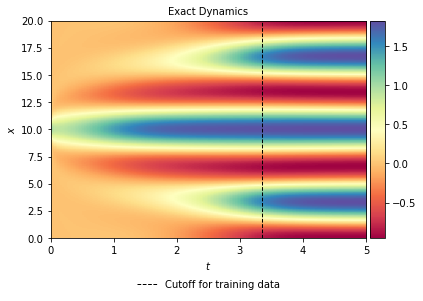

In [98]:
# We plot the true dynamics

fig, ax = plt.subplots()


h = ax.imshow(u_sol, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Dynamics', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_1_discover_exact.pdf', bbox_inches='tight')


fig.show()

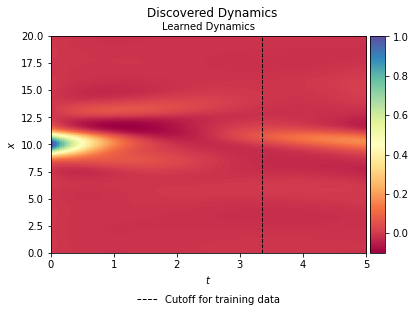

In [52]:
# We plot the dynamics that were learned using PINN from the function N generated by HPM 
fig,ax = plt.subplots()
h = ax.imshow(U_pred, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Discovered Dynamics', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)


fig.savefig('pdfHD_rolls_1_1_discover_pred.pdf', bbox_inches='tight')

fig.show()

#### Learning Dynamics on a Different Data Set
Now we see if the neural network can model a solution with a different initial condition. 

In [53]:
# load the other data for SH
data_sol=scipy.io.loadmat("data/exp1d_HD_even.mat")

In [56]:
Format the data

t_sol = data_sol['tspan'].flatten()[:,None]
x_sol = data_sol['spatial_vec'].flatten()[:,None]
u_sol = np.real(data_sol['data'])

lb_sol=np.array([min(t_sol)[0], min(x_sol)[0]])
ub_sol=np.array([max(t_sol)[0], max(x_sol)[0]])

T_sol, X_sol = np.meshgrid(t_sol,x_sol)

t_sol_col=T_sol.flatten()[:,None]
x_sol_col=X_sol.flatten()[:,None]
dom_sol_col=np.hstack((t_sol_col, x_sol_col))
u_sol_col=u_sol.flatten()[:,None]

Now we make the data a little noisy (if we want)

In [58]:
noise = 0.00
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

Now we choose the training data to construct the solution $u(x,t)$. We will choose a number of points from the initial data at $t = 0$, a number of points containing other boundary data and a number of points from the interior of the domain that function as collocation points for the network $f$ and serve to enforce the structure of the learned PDE.

In [59]:

N0 = u_sol.shape[0]
N_b = u_sol.shape[1]
N_f = 2000


In [60]:
x_indices=np.random.choice(x_sol.shape[0], N0, replace=False)
x0_train=x_sol[x_indices,:]
u0_train=u_sol[x_indices,0:1]

In [61]:
t_indices=np.random.choice(t_sol.shape[0],N_b, replace=False)
tb_train=t_sol[t_indices,:]

In [62]:
X_f_train=lb_sol+(ub_sol-lb_sol)*lhs(2,N_f)

Now we decide how many layers we want and initialize our model.

In [63]:
# first u layer should be the number of inputs (x,t)
u_layers = [2, 50, 50, 50, 50, 1]
# first pde layer should be the number of derivatives needed (max spatial order + max temporal order)
pde_layers = [5, 100, 100, 1]
# for solving -- first layer should be number of inputs, last layer is number of outputs
layers = [2, 50, 50, 50, 50, 1]
    
# Model -- we want to use t_train, x_train, etc from the previous data set to see if the network can extrapolate
model = DeepHPM(t_train, x_train, u_train,
                x0_train, u0_train, tb_train, X_f_train,
                u_layers, pde_layers,
                layers,
                lb_id, ub_id,
                lb_sol, ub_sol)

Now we train the identifier.

In [64]:
model.idn_u_train(N_iter=0)
model.idn_f_train(N_iter=0)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.017312
  Number of iterations: 8933
  Number of functions evaluations: 9368


KeyboardInterrupt: 

Now we train the solver. 

In [ ]:
model.sol_train(N_iter=0)
u_pred, f_pred = model.sol_predict(t_sol_col, x_sol_col)
u_pred_id, f_pred_id = model.sol_predict(t_id_col, x_id_col)

In [ ]:
# print errors
error_u = np.linalg.norm(u_sol_col-u_pred,2)
error_u_id = np.linalg.norm(u_id_col-u_pred_id,2)/np.linalg.norm(u_id_col,2)
print('Relative Error u: %e' % (error_u/np.linalg.norm(u_sol_col,2)))
print('Relative Error u: %e' % (error_u))
print('Error u (idn): %e' % (error_u_id))

U_pred = griddata(dom_sol_col, u_pred.flatten(), (T_sol, X_sol), method='cubic')

Now we plot the true and predicted dynamics. With the choice of initial conditions, we expect to see uniform stripes. 

In [ ]:
# plot as before
fig, ax = plt.subplots()
ax.axis('off')

h = ax.imshow(u_sol, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('True Dynamics', fontsize = 10)
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_2_true.pdf', bbox_inches='tight')
fig.show()

In [ ]:
# plot as before
fig, ax = plt.subplots()
ax.axis('off')
h = ax.imshow(U_pred, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Learned Dynamics', fontsize = 10)
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_2_discover.pdf', bbox_inches='tight')
fig.show()